In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io as spio
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import os
from utils import ImageNode


%load_ext autoreload
%autoreload 2

import time
start_time = time.time()

In [2]:
DISTANCE_THRESHOLD_PERCENTILE = 90
RANSAC_THRESHOLD = 5
SCALE_FACTOR = 0.5

# 1. Load images

In [3]:
data_path = Path(os.getcwd()) / 'isr_wall'

kps_fpaths = sorted((data_path / 'input').glob('kp*.mat'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

imgs_fpaths = sorted((data_path / 'input').glob('*.jpg'),
                     key=lambda x: int(x.stem.split('_')[1])
                    )

ref_kps_fpath = data_path / 'reference' / 'kp_ref.mat'
ref_img_fpath = data_path / 'reference' / 'img_ref.jpg'

In [4]:
# Load keypoints and descriptors supplied

keypoints = [spio.loadmat(fpath)['kp'] for fpath in kps_fpaths]
descriptors = [spio.loadmat(fpath)['desc'] for fpath in kps_fpaths]

ref_keypoints = spio.loadmat(ref_kps_fpath)['kp']
ref_descriptors = spio.loadmat(ref_kps_fpath)['desc']

images = [np.array(Image.open(fpath)) for fpath in imgs_fpaths]
ref_img = np.array(Image.open(ref_img_fpath))

In [ ]:
#Optional: recalculate SIFT with descriptors of size 128

sift = cv2.SIFT_create()

# Extract keypoints and descriptors for each image
keypoints = []
descriptors = []

for img in tqdm(images):
    kps, descs = sift.detectAndCompute(img, None)
    keypoints_array = np.array([kp.pt for kp in kps], dtype=np.float32)
    descs = descs.astype(np.float32)
    keypoints.append(keypoints_array)
    descriptors.append(descs)

# Extract keypoints and descriptors for the reference image
kps, descs = sift.detectAndCompute(ref_img, None)
ref_descriptors = descs.astype(np.float32)
ref_keypoints = np.array([kp.pt for kp in kps], dtype=np.float32)


' #Optional: recalculate SIFT with descriptors of size 128\n\nsift = cv2.SIFT_create()\n\n# Extract keypoints and descriptors for each image\nkeypoints = []\ndescriptors = []\n\nfor img in tqdm(images):\n    kps, descs = sift.detectAndCompute(img, None)\n    keypoints_array = np.array([kp.pt for kp in kps], dtype=np.float32)\n    descs = descs.astype(np.float32)\n    keypoints.append(keypoints_array)\n    descriptors.append(descs)\n\n# Extract keypoints and descriptors for the reference image\nkps, descs = sift.detectAndCompute(ref_img, None)\nref_descriptors = descs.astype(np.float32)\nref_keypoints = np.array([kp.pt for kp in kps], dtype=np.float32) '

In [6]:
from utils import resize_keypoint_and_image


for i in range(len(keypoints)):
    keypoints[i], images[i] = resize_keypoint_and_image(keypoints[i], images[i], SCALE_FACTOR)
    
ref_keypoints, ref_img = resize_keypoint_and_image(ref_keypoints, ref_img, SCALE_FACTOR)


In [7]:
image_nodes = [ImageNode(image, kp, desc, idx) for idx, (image, kp, desc) in enumerate(zip(images, keypoints, descriptors))]
image_node_ref = ImageNode(ref_img, ref_keypoints, ref_descriptors, idx=-1)

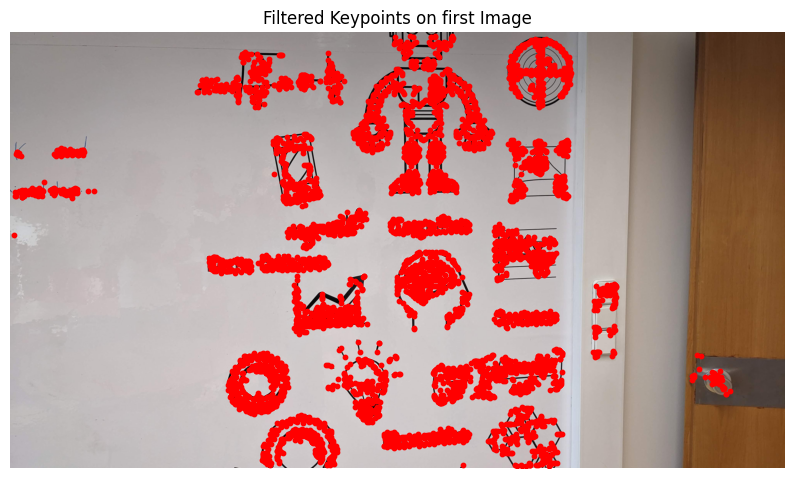

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image_nodes[0].image, cmap='gray')
plt.scatter(image_nodes[0].keypoints[:, 0], image_nodes[0].keypoints[:, 1], c='r', s=10)
plt.title("Filtered Keypoints on first Image")
plt.axis('off')
plt.show()

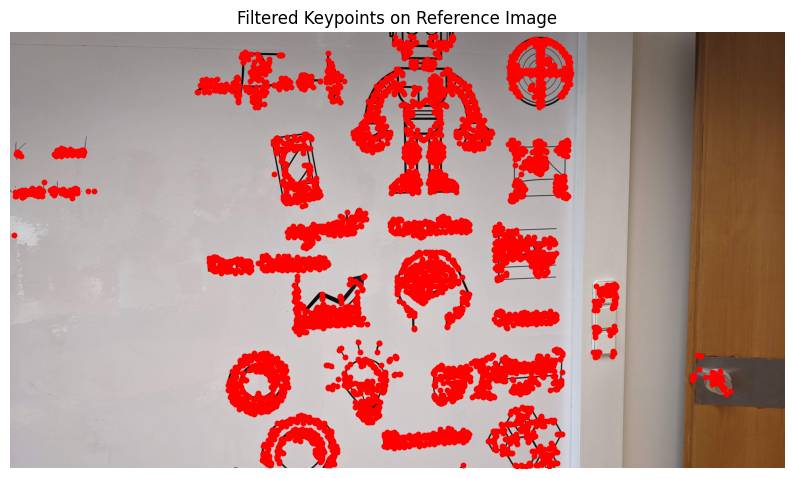

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(ref_img, cmap='gray')
plt.scatter(ref_keypoints[:, 0], ref_keypoints[:, 1], c='r', s=10)
plt.title("Filtered Keypoints on Reference Image")
plt.axis('off')
plt.show()

# 2. Compute thresholds

In [10]:
def find_idx_matches(descs_img_1, descs_img_2, max_desc_dist): #
    matches_idx = []
    for src_idx, desc in enumerate(descs_img_1):
        desc_diffs = descs_img_2 - desc
        norms = np.linalg.norm(desc_diffs, axis=1)
        best_dest_idx = np.argmin(norms)
        
        # Apply distance filter if specified
        if max_desc_dist is None or norms[best_dest_idx] <= max_desc_dist:
            matches_idx.append((src_idx, best_dest_idx))
    
    return matches_idx

def find_keypoint_matches(descs_1, descs_2, keypoints_1, keypoints_2, max_desc_dist): #
    matches_idx = find_idx_matches(descs_1, descs_2, max_desc_dist)
    matches = []

    for src_idx, dest_idx in matches_idx:
        src_kp = keypoints_1[src_idx]
        dest_kp = keypoints_2[dest_idx]
        matches.append([src_kp[0], src_kp[1], dest_kp[0], dest_kp[1]])
    
    return np.array(matches)

def find_matches(src_node, dst_node, max_desc_dist): #
    kp_matches = find_keypoint_matches(
        src_node.descriptors,
        dst_node.descriptors,
        src_node.keypoints,
        dst_node.keypoints,
        max_desc_dist
    )
    src_pts = kp_matches[:, :2]
    dst_pts = kp_matches[:, 2:]

    return src_pts, dst_pts

""" def find_idx_matches(descs_img_1, descs_img_2, max_desc_dist): 

    matches_idx = []
    for src_idx, desc in enumerate(descs_img_1):
        # Compute distances in chunks to save memory
        norms = np.linalg.norm(descs_img_2 - desc, axis=1)
        best_dest_idx = np.argmin(norms)

        # Apply distance filter if specified
        if max_desc_dist is None or norms[best_dest_idx] <= max_desc_dist:
            matches_idx.append((src_idx, best_dest_idx))
    
    return matches_idx

def find_keypoint_matches(descs_1, descs_2, keypoints_1, keypoints_2, max_desc_dist): 

    matches_idx = find_idx_matches(descs_1, descs_2, max_desc_dist)
    matches = np.zeros((len(matches_idx), 4))  # Preallocate array for matches

    for i, (src_idx, dest_idx) in enumerate(matches_idx):
        matches[i, :2] = keypoints_1[src_idx]
        matches[i, 2:] = keypoints_2[dest_idx]
    
    return matches

def find_matches(src_node, dst_node, max_desc_dist): 

    kp_matches = find_keypoint_matches(
        src_node.descriptors,
        dst_node.descriptors,
        src_node.keypoints,
        dst_node.keypoints,
        max_desc_dist
    )
    src_pts = kp_matches[:, :2]
    dst_pts = kp_matches[:, 2:]

    return src_pts, dst_pts """


' def find_idx_matches(descs_img_1, descs_img_2, max_desc_dist): \n\n    matches_idx = []\n    for src_idx, desc in enumerate(descs_img_1):\n        # Compute distances in chunks to save memory\n        norms = np.linalg.norm(descs_img_2 - desc, axis=1)\n        best_dest_idx = np.argmin(norms)\n\n        # Apply distance filter if specified\n        if max_desc_dist is None or norms[best_dest_idx] <= max_desc_dist:\n            matches_idx.append((src_idx, best_dest_idx))\n    \n    return matches_idx\n\ndef find_keypoint_matches(descs_1, descs_2, keypoints_1, keypoints_2, max_desc_dist): \n\n    matches_idx = find_idx_matches(descs_1, descs_2, max_desc_dist)\n    matches = np.zeros((len(matches_idx), 4))  # Preallocate array for matches\n\n    for i, (src_idx, dest_idx) in enumerate(matches_idx):\n        matches[i, :2] = keypoints_1[src_idx]\n        matches[i, 2:] = keypoints_2[dest_idx]\n    \n    return matches\n\ndef find_matches(src_node, dst_node, max_desc_dist): \n\n    kp_ma

In [ ]:
""" def max_descriptor_distance_threshold(image_nodes, distance_threshold_percentile=100):
    all_thresholds = np.array([])
    pair_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    for i in tqdm(range(len(image_nodes) - 1)):
        src_desc = image_nodes[i].descriptors
        dst_desc = image_nodes[i+1].descriptors
        matches = pair_matcher.match(src_desc, dst_desc)
        distances = np.array([m.distance for m in matches])
        curr_threshold = np.percentile(distances, distance_threshold_percentile)
        all_thresholds = np.append(all_thresholds, curr_threshold)

    descriptor_distance_threshold = max(all_thresholds)
    return descriptor_distance_threshold """

from sklearn.neighbors import NearestNeighbors
import numpy as np

def find_idx_matches_aux(descs_img_1, descs_img_2, k=1, algorithm='auto'):
    """
    Finds the nearest neighbors using NearestNeighbors from sklearn.
    """
    nn = NearestNeighbors(n_neighbors=k, algorithm=algorithm, metric='euclidean')
    nn.fit(descs_img_2)
    distances, indices = nn.kneighbors(descs_img_1)  # Find k-nearest neighbors
    matches_idx = np.column_stack((np.arange(len(descs_img_1)), indices[:, 0]))  # Use only the closest match
    return matches_idx, distances[:, 0]

def max_descriptor_distance_threshold(image_nodes, distance_threshold_percentile=100, k=1, algorithm='auto'):
    """
    Optimized function to compute the maximum descriptor distance threshold.
    """
    all_thresholds = []

    for i in tqdm(range(len(image_nodes) - 1)):
        # Extract descriptors for the current pair of nodes
        src_desc = image_nodes[i].descriptors
        dst_desc = image_nodes[i + 1].descriptors

        # Perform matching using NearestNeighbors
        matches_idx, distances = find_idx_matches_aux(src_desc, dst_desc, k=k, algorithm=algorithm)

        # Compute the distance threshold for the current pair
        curr_threshold = np.percentile(distances, distance_threshold_percentile)
        all_thresholds.append(curr_threshold)

    # Maximum threshold across all image pairs
    descriptor_distance_threshold = max(all_thresholds)
    return descriptor_distance_threshold


In [12]:
""" 
# Homography computation
def compute_homography(src_pts, dst_pts):
    num_points = src_pts.shape[0]
    A = []
    
    for i in range(num_points):
        x, y = src_pts[i]
        x_prime, y_prime = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
    
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1]
    H = h.reshape(3, 3)
    return H / H[-1, -1]

# RANSAC

# Given N samples 

# 1) Randomly draw n samples
# 2) Estimate Model
# 3) Select inliers by computing the error and apply threshold

# repeate 1), 2), 3) K times

# 4) Select Model with the most inliers
# 5) reestimade the model with all inliers

def compute_ransac_homography(src_pts, dst_pts, threshold=5.0, K=1000, P=0.99):
    # Compute homography using RANSAC.
    best_H = None
    max_inliers = 0
    n_points = len(src_pts)
    best_inlier_src, best_inlier_dst = None, None
    
    for _ in range(K):
        # 1) Randomly draw 4 samples
        indices = np.random.choice(n_points, 4, replace=False)
        sample_src = src_pts[indices]
        sample_dst = dst_pts[indices]

        # 2) Estimate Model
        try:
            H = compute_homography(sample_src, sample_dst)
        except ValueError:
            # Skip degenerate configurations
            continue

        # 3) Select inliers by computing the error and apply threshold
        # Project all points
        src_homog = np.hstack((src_pts, np.ones((n_points, 1))))  # Convert to homogeneous
        projected_pts = (H @ src_homog.T).T
        projected_pts /= projected_pts[:, 2:3]  # Normalize to inhomogeneous
        distances = np.linalg.norm(projected_pts[:, :2] - dst_pts, axis=1)
        inliers = distances < threshold

        # Update best homography if more inliers are found
        num_inliers = np.sum(inliers)
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inlier_src = src_pts[inliers]
            best_inlier_dst = dst_pts[inliers]

    # 5) Re-estimate model with all inliers
    if max_inliers > 0:
        best_H = compute_homography(best_inlier_src, best_inlier_dst)
    
    return best_inlier_src, best_inlier_dst, best_H

def compute_min_inliers_threshold(image_nodes, max_desc_dist):
    inliers_per_pair = []

    for i in tqdm(range(len(image_nodes) - 1)):
        src_pts, dst_pts = find_matches(image_nodes[i], image_nodes[i+1], max_desc_dist)
        inliers, _, H = compute_ransac_homography(src_pts, dst_pts, threshold=5.0, K=10000, P=0.99)
        inliers_per_pair.append(len(inliers))
        print(inliers)

    min_inliers = min(inliers_per_pair)
    return min_inliers """

def compute_homography(src_pts, dst_pts):
    num_points = src_pts.shape[0]
    A = np.zeros((2 * num_points, 9))
    
    X, Y = src_pts[:, 0], src_pts[:, 1]
    X_prime, Y_prime = dst_pts[:, 0], dst_pts[:, 1]

    A[0::2, :3] = np.column_stack((-X, -Y, -np.ones(num_points)))
    A[1::2, 3:6] = np.column_stack((-X, -Y, -np.ones(num_points)))
    A[0::2, 6:] = np.column_stack((X * X_prime, Y * X_prime, X_prime))
    A[1::2, 6:] = np.column_stack((X * Y_prime, Y * Y_prime, Y_prime))

    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[-1, -1]

def compute_ransac_homography(src_pts, dst_pts, threshold=5.0, K=1000):
    best_H = None
    max_inliers = 0
    n_points = len(src_pts)
    best_inlier_src, best_inlier_dst = None, None

    src_homog = np.hstack((src_pts, np.ones((n_points, 1))))  # Convert to homogeneous

    for _ in range(K):
        # 1) Randomly draw 4 samples
        indices = np.random.choice(n_points, 4, replace=False)
        sample_src = src_pts[indices]
        sample_dst = dst_pts[indices]

        # 2) Estimate Model
        try:
            H = compute_homography(sample_src, sample_dst)
        except np.linalg.LinAlgError:
            continue  # Skip degenerate configurations

        # 3) Select inliers
        projected_pts = (H @ src_homog.T).T
        projected_pts /= projected_pts[:, 2:3]  # Normalize
        distances = np.linalg.norm(projected_pts[:, :2] - dst_pts, axis=1)
        inliers = distances < threshold

        num_inliers = np.sum(inliers)
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inlier_src = src_pts[inliers]
            best_inlier_dst = dst_pts[inliers]

    # 5) Re-estimate model with all inliers
    if max_inliers > 0:
        best_H = compute_homography(best_inlier_src, best_inlier_dst)
    
    return best_inlier_src, best_inlier_dst, best_H

def compute_min_inliers_threshold(image_nodes, max_desc_dist):
    inliers_per_pair = []

    for i in tqdm(range(len(image_nodes) - 1)):
        src_pts, dst_pts = find_matches(image_nodes[i], image_nodes[i+1], max_desc_dist)
        inliers, _, _ = compute_ransac_homography(src_pts, dst_pts, threshold=5.0, K=1000)
        inliers_per_pair.append(len(inliers))
        print(len(inliers))

    return min(inliers_per_pair)

In [13]:
max_desc_dist = max_descriptor_distance_threshold(image_nodes, DISTANCE_THRESHOLD_PERCENTILE)
print('The maximum descriptor distance is:', round(max_desc_dist, 4))

  0%|          | 0/8 [00:00<?, ?it/s]


TypeError: find_idx_matches() missing 1 required positional argument: 'max_desc_dist'

In [ ]:
min_inliers_threshold = compute_min_inliers_threshold(image_nodes, max_desc_dist)
print('The minimum number of inliers is:', min_inliers_threshold)

# 3. Compute homographies

In [ ]:
def find_valid_homography(src_node, dst_node, min_inliers_threshold, max_desc_dist):
    src_pts, dst_pts = find_matches(src_node, dst_node, max_desc_dist)
    # print(f'Number of matches: {len(src_pts)}')
    inliers, _, H = compute_ransac_homography(src_pts, dst_pts, threshold=5.0, K=10000)
    num_inliers = len(inliers)
    is_H_valid = 1 if num_inliers >= min_inliers_threshold else 0
    return H, is_H_valid, num_inliers

In [ ]:
def find_direct_homographies(image_nodes, image_node_ref, min_inliers_threshold, max_desc_dist):
    valid_homographies = {1: []}

    for i in tqdm(range(len(image_nodes))):
        H, is_H_valid, num_inliers = find_valid_homography(image_nodes[i], image_node_ref, min_inliers_threshold, max_desc_dist)
        
        if is_H_valid:
            image_nodes[i].homography = H
            image_nodes[i].footprint.append('ref')
            valid_homographies[1].append(i)
    return valid_homographies

valid_homographies = find_direct_homographies(image_nodes, image_node_ref, min_inliers_threshold, max_desc_dist)

In [ ]:
from itertools import chain

def find_remaining_homographies(image_nodes, valid_homographies, min_inliers_threshold, max_desc_dist):
    level = 1
    while level in valid_homographies:
        best_idxs = valid_homographies[level]
        for node in tqdm(image_nodes):
            if node.idx in list(chain.from_iterable(valid_homographies.values())):
                continue

            nearest_idx = min(best_idxs, key=lambda x: abs(x - node.idx))
            H, is_H_valid, num_inliers = find_valid_homography(node, image_nodes[nearest_idx], min_inliers_threshold, max_desc_dist)

            if is_H_valid:
                node.homography = np.dot(image_nodes[nearest_idx].homography, H)
                valid_homographies.setdefault(level + 1, []).append(node.idx)
                node.footprint.extend(image_nodes[nearest_idx].footprint)
        level += 1

find_remaining_homographies(image_nodes, valid_homographies, min_inliers_threshold, max_desc_dist)

# 4. Visualize results

## 4.1 Visualize matches

In [ ]:
from plot import draw_matches_points


def show_keypoints_matches(node1, node2, max_desc_dist, num_matches):
    """
    Show the keypoints matches between two image nodes.

    Args:
        node1 (ImageNode): The first image node.
        node2 (ImageNode): The second image node.
    """
    src_pts, dst_pts = find_matches(node1, node2, max_desc_dist)

    img_matches = draw_matches_points(node1.image, node2.image, src_pts, dst_pts, num_matches)

    # Display the matches
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.title(f"Keypoints Matches between Image {node1.idx} and Image {node2.idx}")
    plt.axis('off')
    plt.show()

In [ ]:
# counter = 0
# num_plots = 1000
# for node in image_nodes:
#     if counter == num_plots:
#         break
#     if node.footprint == ['ref']:
#         show_keypoints_matches(node, image_node_ref, max_desc_dist, num_matches=50)
#         counter += 1

## 4.2 Visualize inlier matches

In [ ]:
def show_inlier_matches(node1, node2, max_desc_dist=None, ransac_threshold=RANSAC_THRESHOLD, max_points=None):
    """
    Finds matches between two image nodes, computes a homography, and
    visualizes only the inlier matches.

    Args:
        node1 (ImageNode): The first image node (has .image, .keypoints, .descriptors).
        node2 (ImageNode): The second image node.
        max_desc_dist (float, optional): Maximum descriptor distance to keep a match.
        ransac_threshold (float): Threshold for RANSAC homography.
        max_points (int or None): If int, draw up to this many inlier points.
                                  If None, draw all inliers.
    """
    # 1) Find initial descriptor matches + their points
    src_pts, dst_pts = find_matches(node1, node2, max_desc_dist)

    # 2) Compute homography and get RANSAC's inlier mask
    """ H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_threshold)
    if mask is None:
        print("No homography could be computed.")
        return

    # 3) Filter only inlier points
    inlier_indices = np.where(mask.flatten() == 1)[0]
    inlier_src_pts = src_pts[inlier_indices]
    inlier_dst_pts = dst_pts[inlier_indices] """
    inlier_src_pts, inlier_dst_pts, H = compute_ransac_homography(src_pts, dst_pts, threshold=5.0, K=10000)

    # 4) Draw the inlier matches in a side-by-side image
    out_image = draw_matches_points(
        node1.image, node2.image,
        inlier_src_pts, inlier_dst_pts,
        max_points=max_points
    )

    # 5) Show the result
    plt.figure(figsize=(12, 6))
    plt.imshow(out_image)
    plt.title(f"Inlier Matches between Node {node1.idx} and Node {node2.idx}")
    plt.axis("off")
    plt.show()

In [ ]:
# counter = 0
# num_plots = 1000
# for node in image_nodes:
#     if counter == num_plots:
#         break
#     if node.footprint == ['ref']:
#         visualize_inlier_matches(node, image_node_ref, max_desc_dist, RANSAC_THRESHOLD, 50)
#         counter += 1

# 4.3 Visualize path inlier matches

In [ ]:
from utils import print_footprints

print_footprints(image_nodes)

In [ ]:
starting_node = image_nodes[2]
num_matches = 50
for idx in range(len(starting_node.footprint)-1):
    if starting_node.footprint[idx+1] == 'ref':
        show_inlier_matches(image_nodes[starting_node.footprint[idx]], image_node_ref, max_desc_dist, RANSAC_THRESHOLD, num_matches)
    if idx + 1 < len(starting_node.footprint) and starting_node.footprint[idx+1] != 'ref':
        show_inlier_matches(image_nodes[starting_node.footprint[idx]], image_nodes[starting_node.footprint[idx + 1]], max_desc_dist, RANSAC_THRESHOLD, num_matches)
    

In [ ]:
from plot import create_canvas_with_images

# Example usage:
final_canvas = create_canvas_with_images(ref_img, image_nodes)

# Display the final canvas
plt.figure(figsize=(20, 20))
plt.imshow(final_canvas)
plt.title("Final Canvas with All Images in Reference Frame")
plt.axis('off')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")